# Import the dependencies

In [1]:
import re
import random
import numpy as np
import pandas as pd

from tqdm import tqdm

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, LSTM
from keras.callbacks import ModelCheckpoint

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

from matplotlib import pyplot as plt

import sys
import time

sys.path.append("../")
from calculus_path_mod.terms.pseudonym import *
from calculus_path_mod.reduction_strategy import *
from calculus_path_mod.terms.arithm_complex_ops import *

In [2]:
epochs = 25
num_neurons = 128
onehot_dims = 4

# Load & Prepare the data

In [3]:
enc_dict = {"(": [1.0, .0, .0, .0],
            ")": [.0, 1.0, .0, .0],
            "x": [.0, .0, 1.0, .0],
            "@x.": [.0, .0, .0, 1.0]}
tokens_pattern = r"(\(|\)|@x\.|x)"


def tokenize_data(simplified_term):
    return re.findall(tokens_pattern, simplified_term)


def tokenize_and_vectorize(x_data):
    vectorized_data_ = []
    for sample_ in x_data:
        tokens_ = tokenize_data(sample_)
        sample_vecs_ = []
        for token_ in tokens_:
            try:
                sample_vecs_.append(enc_dict[token_])
            except KeyError:
                pass
        vectorized_data_.append(sample_vecs_)
    return vectorized_data_

In [4]:
all_data = pd.read_csv("./data/steps_simple_term_str.csv", delimiter=',')

# leave only unique terms
print(f"Count all terms: {len(all_data)}\n")
all_data = all_data.drop_duplicates(subset="simple_terms").reset_index(drop=True)
print(f"Count original terms: {len(all_data)}\n")

# shuffle the dataset
all_data = shuffle(all_data, random_state=33).reset_index(drop=True)

# filter out steps_lo that are more than 30
all_data = all_data[[steps_lo < 31 for steps_lo in all_data['steps_num_lo']]]

print(f"max steps count: {max(all_data['steps_num_lo'])}")
print(f"min steps count: {min(all_data['steps_num_lo'])}")

# make test/train split
x_train, x_test, y_train, y_test = train_test_split(all_data["simple_terms"].tolist(), all_data["steps_num_lo"].tolist(),
                                                    test_size=0.2, random_state=42)

print(f"Count training samples: {len(y_train)}")
print(f"Count testing samples: {len(y_test)}")

Count all terms: 4251

Count original terms: 4251

max steps count: 30
min steps count: 0
Count training samples: 2952
Count testing samples: 739


In [5]:
# one-hot encode y-data
encoder = LabelBinarizer()
encoder.fit(range(0, 31))
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

x_train = tokenize_and_vectorize(x_train)
x_test = tokenize_and_vectorize(x_test)

In [6]:
xy_train_data = list(zip(x_train, y_train))
xy_test_data = list(zip(x_test, y_test))

In [7]:
print(f"len(test_data) = {len(xy_test_data)}")
print(f"len(train_data) = {len(xy_train_data)}")

len(test_data) = 739
len(train_data) = 2952


In [12]:
def train_generator():
    while True:
        random.shuffle(xy_train_data)
        for xtd, ytd in xy_train_data:
            yield np.array([xtd]), np.array([ytd])


def test_generator():
    while True:
        for xtd, ytd in xy_test_data:
            yield np.array([xtd]), np.array([ytd])

# Define the model

In [13]:
model = Sequential()
model.add(LSTM(units=num_neurons,
               input_shape=(None, onehot_dims)))
model.add(Dense(units=31, activation='softmax'))

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               68096     
                                                                 
 dense (Dense)               (None, 31)                3999      
                                                                 
Total params: 72095 (281.62 KB)
Trainable params: 72095 (281.62 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [15]:
model_structure = model.to_json()
with open("./fine_models/v0_lstm_steps_pred_31.json", 'w') as json_file:
    json_file.write(model_structure)

In [18]:
# Define the ModelCheckpoint callback
checkpoint_callback = ModelCheckpoint(
    filepath='./fine_models/v0_lstm_steps_pred_31.h5',  # Specify the path to save the best model
    monitor='accuracy',  # Metric to monitor (e.g., validation loss)
    save_best_only=True,  # Save only the best model
    mode='max',  # 'min' or 'max' depending on the monitored metric
    verbose=0  # Print a message when saving the model
)

In [19]:
history = model.fit(train_generator(), steps_per_epoch=2952, epochs=epochs, verbose=1, callbacks=[checkpoint_callback])

Epoch 1/25
2952/2952 [==============================] - 69s 23ms/step - loss: 2.8426 - accuracy: 0.1280
Epoch 2/25
   8/2952 [..............................] - ETA: 48s - loss: 2.3881 - accuracy: 0.1250

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2952/2952 [==============================] - 62s 21ms/step - loss: 2.6864 - accuracy: 0.1419
Epoch 3/25
2952/2952 [==============================] - 59s 20ms/step - loss: 2.6400 - accuracy: 0.1572
Epoch 4/25
2952/2952 [==============================] - 59s 20ms/step - loss: 2.6233 - accuracy: 0.1433
Epoch 5/25
2952/2952 [==============================] - 59s 20ms/step - loss: 2.7741 - accuracy: 0.1348
Epoch 6/25
2952/2952 [==============================] - 60s 20ms/step - loss: 2.6621 - accuracy: 0.1443
Epoch 7/25
2952/2952 [==============================] - 59s 20ms/step - loss: 2.5724 - accuracy: 0.1606
Epoch 8/25
2952/2952 [==============================] - 58s 20ms/step - loss: 2.5520 - accuracy: 0.1707
Epoch 9/25
2952/2952 [==============================] - 58s 20ms/step - loss: 2.5225 - accuracy: 0.1721
Epoch 10/25
2952/2952 [==============================] - 59s 20ms/step - loss: 2.6616 - accuracy: 0.1626
Epoch 11/25
2952/2952 [==============================] - 58s 20ms/step - l

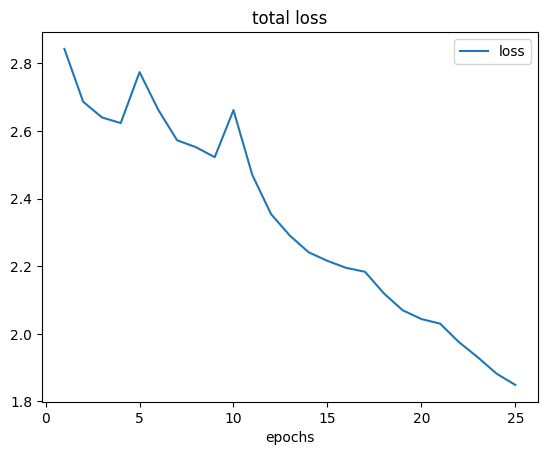

In [20]:
plt.plot(range(1, epochs + 1), history.history['loss'], label="loss")
plt.xlabel("epochs")
plt.title("total loss")

plt.legend()
plt.show()

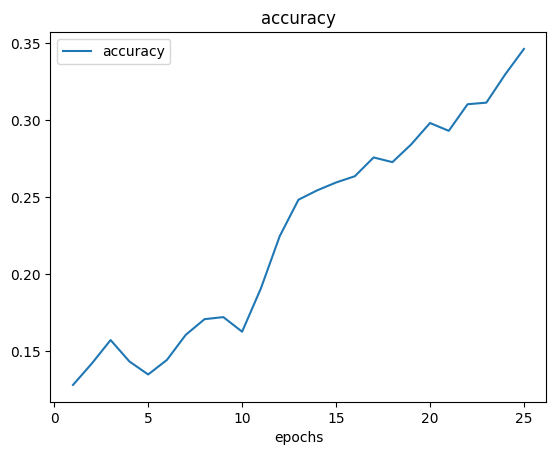

In [21]:
plt.plot(range(1, epochs + 1), history.history['accuracy'], label="accuracy")
plt.xlabel("epochs")
plt.title("accuracy")

plt.legend()
plt.show()

In [22]:
history = model.fit(train_generator(), steps_per_epoch=2952, epochs=epochs, verbose=1, callbacks=[checkpoint_callback])

Epoch 1/25
2952/2952 [==============================] - 69s 24ms/step - loss: 1.7983 - accuracy: 0.3455
Epoch 2/25
2952/2952 [==============================] - 76s 26ms/step - loss: 1.7648 - accuracy: 0.3635
Epoch 3/25
   6/2952 [..............................] - ETA: 1:19 - loss: 2.0895 - accuracy: 0.1667    

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2952/2952 [==============================] - 74s 25ms/step - loss: 1.7272 - accuracy: 0.3560
Epoch 4/25
2952/2952 [==============================] - 75s 26ms/step - loss: 1.6805 - accuracy: 0.3926
Epoch 5/25
2952/2952 [==============================] - 79s 27ms/step - loss: 1.6650 - accuracy: 0.3919
Epoch 6/25
2952/2952 [==============================] - 78s 26ms/step - loss: 1.6175 - accuracy: 0.4055
Epoch 7/25
2952/2952 [==============================] - 76s 26ms/step - loss: 1.5729 - accuracy: 0.4089
Epoch 8/25
2952/2952 [==============================] - 76s 26ms/step - loss: 1.5291 - accuracy: 0.4329
Epoch 9/25
2952/2952 [==============================] - 79s 27ms/step - loss: 1.5447 - accuracy: 0.4248
Epoch 10/25
2952/2952 [==============================] - 76s 26ms/step - loss: 1.4836 - accuracy: 0.4390
Epoch 11/25
2952/2952 [==============================] - 75s 25ms/step - loss: 1.4402 - accuracy: 0.4610
Epoch 12/25
2952/2952 [==============================] - 74s 25ms/step - 

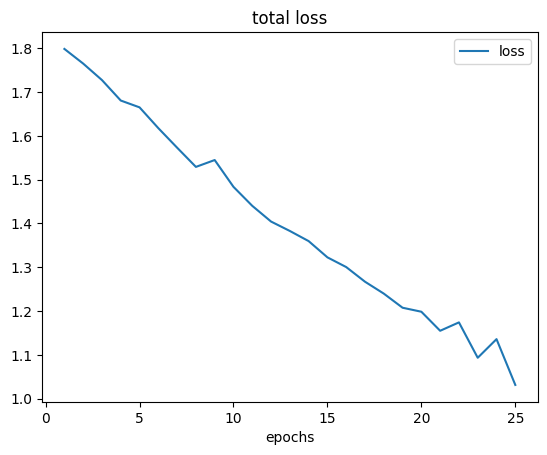

In [23]:
plt.plot(range(1, epochs + 1), history.history['loss'], label="loss")
plt.xlabel("epochs")
plt.title("total loss")

plt.legend()
plt.show()

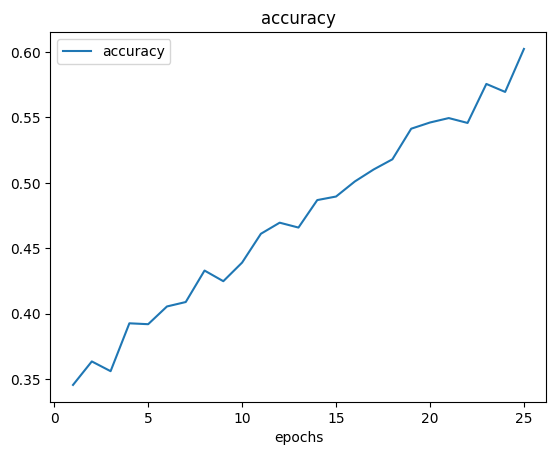

In [24]:
plt.plot(range(1, epochs + 1), history.history['accuracy'], label="accuracy")
plt.xlabel("epochs")
plt.title("accuracy")

plt.legend()
plt.show()

In [25]:
history = model.fit(train_generator(), steps_per_epoch=2952, epochs=epochs, verbose=1, callbacks=[checkpoint_callback])

Epoch 1/25
2952/2952 [==============================] - 72s 24ms/step - loss: 0.9451 - accuracy: 0.6277
Epoch 2/25
   4/2952 [..............................] - ETA: 1:05 - loss: 0.7098 - accuracy: 0.7500    

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2952/2952 [==============================] - 74s 25ms/step - loss: 1.0430 - accuracy: 0.6003
Epoch 3/25
2952/2952 [==============================] - 73s 25ms/step - loss: 1.0481 - accuracy: 0.6023
Epoch 4/25
2952/2952 [==============================] - 73s 25ms/step - loss: 1.0330 - accuracy: 0.6098
Epoch 5/25
2952/2952 [==============================] - 71s 24ms/step - loss: 1.0150 - accuracy: 0.6094
Epoch 6/25
2952/2952 [==============================] - 70s 24ms/step - loss: 0.9699 - accuracy: 0.6287
Epoch 7/25
2952/2952 [==============================] - 75s 25ms/step - loss: 0.9890 - accuracy: 0.6138
Epoch 8/25
2952/2952 [==============================] - 77s 26ms/step - loss: 0.9794 - accuracy: 0.6216
Epoch 9/25
2952/2952 [==============================] - 69s 23ms/step - loss: 0.9382 - accuracy: 0.6491
Epoch 10/25
2952/2952 [==============================] - 68s 23ms/step - loss: 0.9270 - accuracy: 0.6402
Epoch 11/25
2952/2952 [==============================] - 64s 22ms/step - l

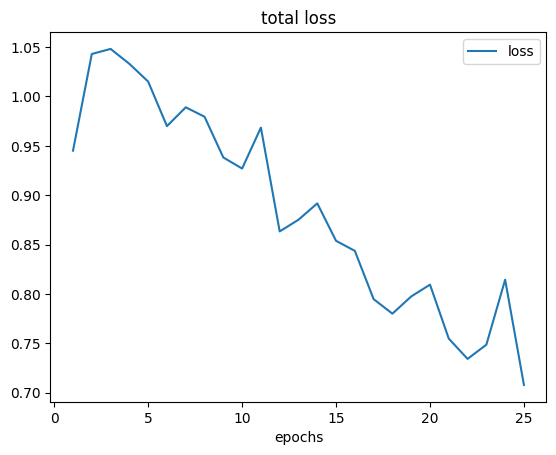

In [26]:
plt.plot(range(1, epochs + 1), history.history['loss'], label="loss")
plt.xlabel("epochs")
plt.title("total loss")

plt.legend()
plt.show()

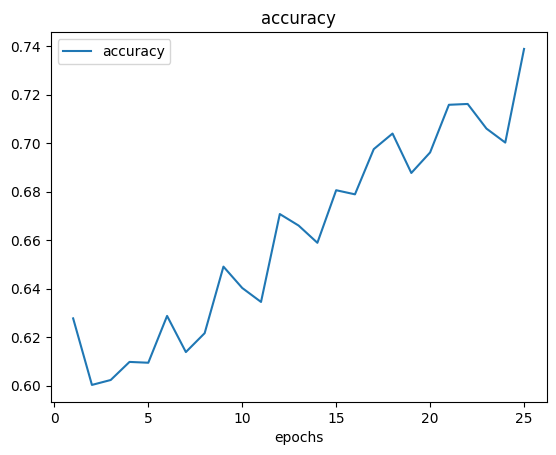

In [27]:
plt.plot(range(1, epochs + 1), history.history['accuracy'], label="accuracy")
plt.xlabel("epochs")
plt.title("accuracy")

plt.legend()
plt.show()

In [28]:
history = model.fit(train_generator(), steps_per_epoch=2952, epochs=epochs, verbose=1, callbacks=[checkpoint_callback])

Epoch 1/25
2952/2952 [==============================] - 69s 23ms/step - loss: 0.7520 - accuracy: 0.7077
Epoch 2/25
2952/2952 [==============================] - 75s 25ms/step - loss: 0.6715 - accuracy: 0.7439
Epoch 3/25
   5/2952 [..............................] - ETA: 1:36 - loss: 0.7227 - accuracy: 0.6000

D:\documents\python_projects\pure-calculus\venv_3_11\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2952/2952 [==============================] - 78s 26ms/step - loss: 0.7575 - accuracy: 0.7182
Epoch 4/25
2952/2952 [==============================] - 76s 26ms/step - loss: 0.7375 - accuracy: 0.7226
Epoch 5/25
2952/2952 [==============================] - 76s 26ms/step - loss: 0.6884 - accuracy: 0.7368
Epoch 6/25
2952/2952 [==============================] - 75s 25ms/step - loss: 0.6984 - accuracy: 0.7273
Epoch 7/25
2952/2952 [==============================] - 75s 26ms/step - loss: 0.6507 - accuracy: 0.7514
Epoch 8/25
2952/2952 [==============================] - 75s 26ms/step - loss: 0.6845 - accuracy: 0.7405
Epoch 9/25
2952/2952 [==============================] - 75s 25ms/step - loss: 0.6871 - accuracy: 0.7429
Epoch 10/25
2952/2952 [==============================] - 63s 21ms/step - loss: 0.6265 - accuracy: 0.7707
Epoch 11/25
2952/2952 [==============================] - 62s 21ms/step - loss: 0.6244 - accuracy: 0.7673
Epoch 12/25
2952/2952 [==============================] - 72s 24ms/step - 

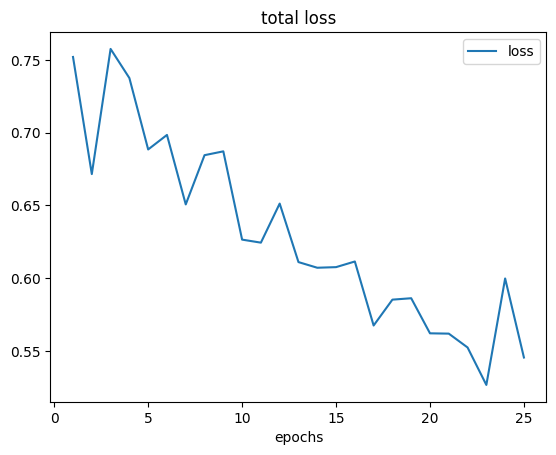

In [29]:
plt.plot(range(1, epochs + 1), history.history['loss'], label="loss")
plt.xlabel("epochs")
plt.title("total loss")

plt.legend()
plt.show()

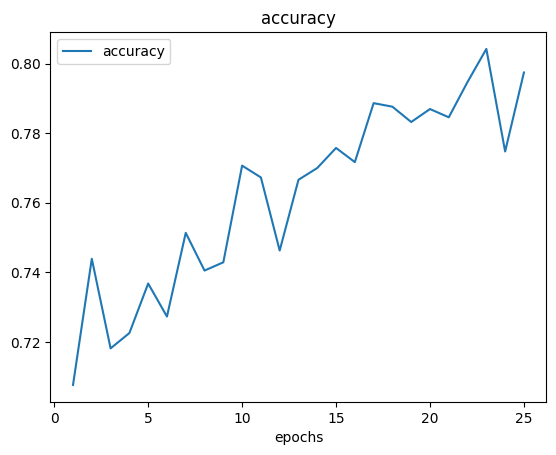

In [30]:
plt.plot(range(1, epochs + 1), history.history['accuracy'], label="accuracy")
plt.xlabel("epochs")
plt.title("accuracy")

plt.legend()
plt.show()

In [31]:
y_test_pred = []
for x_ in x_test:
    y_test_pred.append(model.predict(np.array([x_]), verbose=0)[0])

In [8]:
def draw_pred_lines(y_pred, y_real):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    for key_, val_ in drawing_df.items():
        plt.plot(range(len(val_)), val_, label=key_)

    plt.xlabel("No")
    plt.ylabel("Redexes count")
    plt.title("Pred vs Real Step Time")
    plt.legend()
    plt.show()

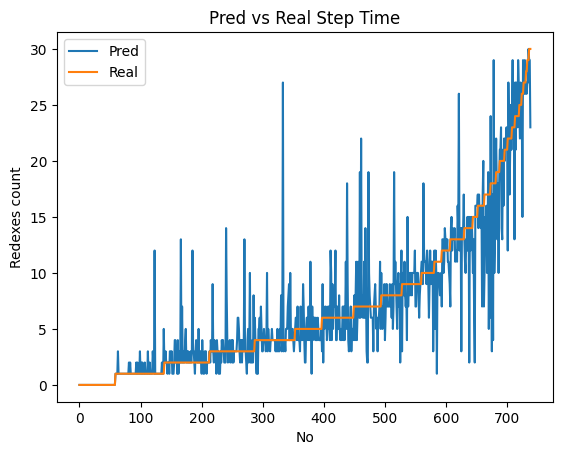

In [33]:
y_test_pred_nums = encoder.inverse_transform(np.array(y_test_pred))
y_test_nums = encoder.inverse_transform(y_test)

draw_pred_lines(y_test_pred_nums, y_test_nums)

In [34]:
def calculate_accuracy(actual_labels, predicted_labels):
    correct_predictions = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
    total_predictions = len(actual_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy


print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))

Test accuracy: 0.30311231393775373


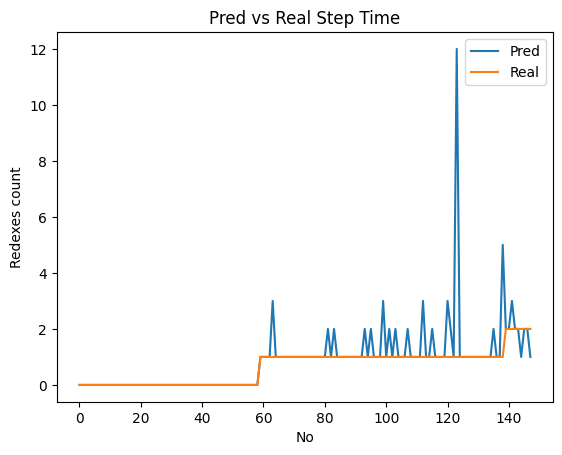

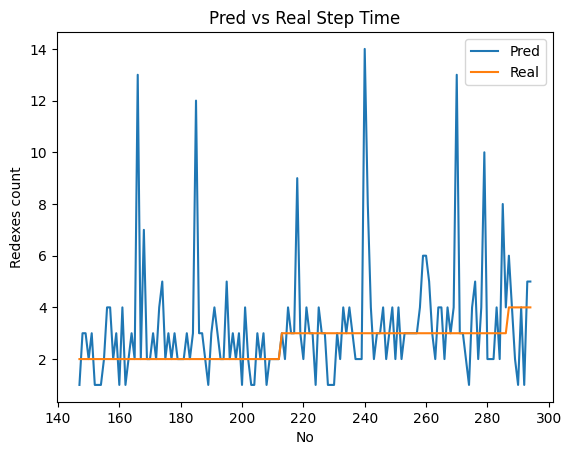

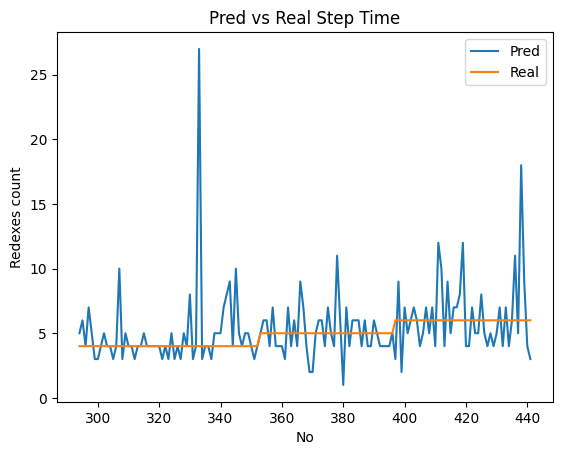

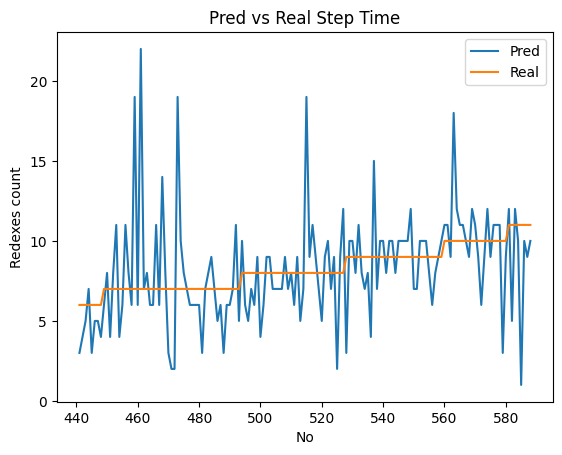

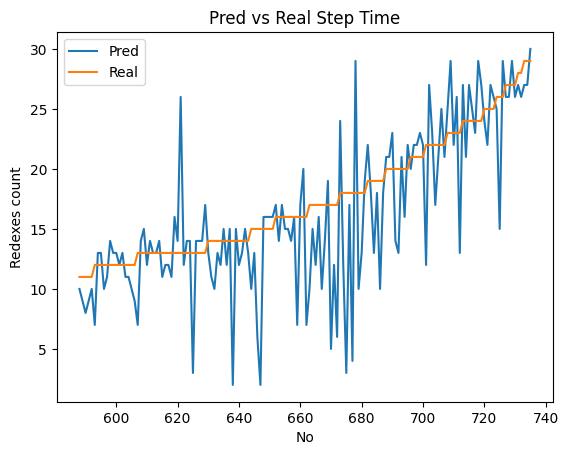

In [35]:
def draw_pred_lines_steps(y_pred, y_real, ranges):
    drawing_df = pd.DataFrame({"Pred": y_pred, "Real": y_real})
    drawing_df = drawing_df.sort_values("Real").reset_index(drop=True)

    range_step = int(len(y_pred) / ranges)
    for range_no in range(ranges):
        for key_, val_ in drawing_df.items():
            plt.plot(range(range_no * range_step, ((range_no + 1) * range_step) + 1), val_[range_no * range_step : ((range_no + 1) * range_step) + 1], label=key_)

        plt.xlabel("No")
        plt.ylabel("Redexes count")
        plt.title("Pred vs Real Step Time")
        plt.legend()
        plt.show()


draw_pred_lines_steps(y_test_pred_nums, y_test_nums, 5)

In [ ]:
y_train

In [38]:
def ite_term():
    x, y, c = Var(), Var(), Var()
    x_, y_, c_ = Atom(x), Atom(y), Atom(c)
    return Lambda(c, Lambda(x, Lambda(y, multi_app_term(c_, x_, y_))))


def true_term():
    x, y = Var(), Var()
    x_ = Atom(x)
    return Lambda(x, Lambda(y, x_))


def num_zero_term():
    s, z = Var(), Var()
    z_ = Atom(z)
    return Lambda(s, Lambda(z, z_))


def num_term(n: int):
    if n <= 0:
        return num_zero_term()
    s, z = Var(), Var()
    s_, z_ = Atom(s), Atom(z)
    core_term = App(s_, z_)
    for _ in range(n - 1):
        core_term = App(s_, core_term)
    return Lambda(s, Lambda(z, core_term))


def multi_app_term(term_0: Term, term_1: Term, *terms: Term):
    res_app_term = App(term_0, term_1)
    for term in terms:
        res_app_term = App(res_app_term, term)
    return res_app_term


def false_term():
    x, y = Var(), Var()
    y_ = Atom(y)
    return Lambda(x, Lambda(y, y_))


def pair_term():
    x, y, p = Var(), Var(), Var()
    x_, y_, p_ = Atom(x), Atom(y), Atom(p)
    return Lambda(x, Lambda(y, Lambda(p, multi_app_term(p_, x_, y_))))


def first_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(p, App(p_, true_term()))


def second_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(p, App(p_, false_term()))


def succ_term():
    x, y, n = Var(), Var(), Var()
    x_, y_, n_ = Atom(x), Atom(y), Atom(n)
    return Lambda(n, Lambda(x, Lambda(y, App(x_, multi_app_term(n_, x_, y_)))))


def sinc_term():
    p = Var()
    p_ = Atom(p)
    return Lambda(
        p,
        multi_app_term(
            pair_term(),
            App(second_term(), p_),
            App(succ_term(), App(second_term(), p_)),
        ),
    )


def pred_term():
    n, f, x, g, h, u = Var(), Var(), Var(), Var(), Var(), Var()
    n_, f_, x_ = Atom(n), Atom(f), Atom(x)
    g_, h_, u_ = Atom(g), Atom(h), Atom(u)

    return Lambda(n, Lambda(f, Lambda(x, multi_app_term(
        n_,
        Lambda(g, Lambda(h, App(h_, App(g_, f_)))),
        Lambda(u, x_),
        Lambda(u, u_)
    ))))


def plus_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(m, Lambda(n, multi_app_term(n_, succ_term(), m_)))


def subtract_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(n, Lambda(m, multi_app_term(m_, pred_term(), n_)))


def iszero_term():
    x, n = Var(), Var()
    n_ = Atom(n)
    return Lambda(n, App(App(n_, Lambda(x, false_term())), true_term()))


def leq_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(
        n, Lambda(m, App(iszero_term(), multi_app_term(subtract_term(), n_, m_)))
    )


def and_term():
    a, b = Var(), Var()
    a_, b_ = Atom(a), Atom(b)
    return Lambda(a, Lambda(b, multi_app_term(ite_term(), a_, b_, a_)))


def eq_term():
    n, m = Var(), Var()
    n_, m_ = Atom(n), Atom(m)
    return Lambda(
        n,
        Lambda(
            m,
            multi_app_term(
                and_term(),
                multi_app_term(leq_term(), n_, m_),
                multi_app_term(leq_term(), m_, n_),
            ),
        ),
    )


def i_term():
    x = Var()
    x_ = Atom(x)
    return Lambda(x, x_)


def omega_term(n: int):
    x = Var()
    x_ = Atom(x)
    body_app_term = x_
    for _ in range(n - 1):
        body_app_term = App(body_app_term, x_)
    return Lambda(x, body_app_term)


def multi_i_term(m: int):
    app_term = i_term()
    for _ in range(m - 1):
        app_term = App(app_term, i_term())
    return app_term


def omega_multi_i_term(n: int, m: int):
    return App(omega_term(n), multi_i_term(m))


def term_test_1():
    x, y = Var(), Var()
    x_, y_ = Atom(x), Atom(y)

    return "(λx. (λy.y)) ((λx. (xx)) (λx. (xx))) == I == λx. x", \
        App(
            Lambda(x, Lambda(y, y_)),
            App(
                Lambda(x, App(x_, x_)),
                Lambda(x, App(x_, x_))
            )
        )


def term_test_2():
    return "(ITE TRUE 3 1) == 3 == λx. λy. (x (x (x y)))", \
        multi_app_term(ite_term(), true_term(), num_term(3), num_term(1))


def term_test_3():
    return "(ITE FALSE 0 4) == 4 == λx. λy. (x (x (x (x y))))", \
        multi_app_term(ite_term(), false_term(), num_term(0), num_term(4))


def term_test_4():
    return "(PRED 0) == 0 == λx. λy. y", \
        multi_app_term(pred_term(), num_term(0))


def term_test_5():
    return "(PRED 5) == 4 == λx. λy. (x (x (x (x y))))", \
        multi_app_term(pred_term(), num_term(5))


def term_test_6():
    return "(PLUS 0 0) == 0 == λx. λy. y", \
        multi_app_term(plus_term(), num_term(0), num_term(0))


def term_test_7():
    return "(PLUS 2 3) == 5 == λx. λy. (x (x (x (x (x y)))))", \
        multi_app_term(plus_term(), num_term(2), num_term(3))


def term_test_8():
    return "(SUBTRACT 4 1) == 3 == λx. λy. (x (x (x y)))", \
        multi_app_term(subtract_term(), num_term(4), num_term(1))


def term_test_9():
    return "(SUBTRACT 3 5) == 0 == λx. λy. y", \
        multi_app_term(subtract_term(), num_term(3), num_term(5))


def term_test_10():
    return "(LEQ 3 2) == FALSE == λx. λy. y", \
        multi_app_term(leq_term(), num_term(3), num_term(2))


def term_test_11():
    return "(LEQ 2 5) == TRUE == λx. λy. x", \
        multi_app_term(leq_term(), num_term(2), num_term(5))


def term_test_12():
    return "(EQ 2 2) == TRUE == λx. λy. x", \
        multi_app_term(eq_term(), num_term(2), num_term(2))


def term_test_13():
    return "(EQ 1 4) == FALSE == λx. λy. y", \
        multi_app_term(eq_term(), num_term(1), num_term(4))


def term_test_14():
    return "Omega(3, 3)  == I == λx. x", \
        omega_multi_i_term(3, 3)


def term_test_15():
    return "GCD_vO 5 2", \
        multi_app_term(gcd_term_v0(), num_term(5), num_term(2))


def term_test_16():
    return "GCD_v1 5 2", \
        multi_app_term(gcd_term_v1(), num_term(5), num_term(2))


def term_test_17():
    return "GCD_v3 5 2", \
        multi_app_term(gcd_term_v3(), num_term(5), num_term(2))


def term_test_18():
    return "PYTHAGOREAN 5 2 2", \
        multi_app_term(
            pythagorean_term(), num_term(5), num_term(2), num_term(2)
        )


def test_function(term_deskr_: str, term_: Term, model_: Sequential):
    prediction_ = model_.predict(tokenize_and_vectorize([term_.simple_str()]), verbose=0)
    print(f"{term_deskr_}\nnorm_steps={term_.normalize(LOStrategy())[1]}\tpred_steps={np.argmax(prediction_[0])}\n")


list_test_functions = (term_test_1, term_test_2, term_test_3, term_test_4, term_test_5, term_test_6, term_test_7, term_test_9, term_test_10, term_test_11, term_test_12, term_test_13, term_test_14, term_test_15, term_test_16, term_test_17, term_test_18)

for term_function in list_test_functions:
    term_deskr, term = term_function()
    test_function(term_deskr, term, model)

(λx. (λy.y)) ((λx. (xx)) (λx. (xx))) == I == λx. x
norm_steps=1	pred_steps=2

(ITE TRUE 3 1) == 3 == λx. λy. (x (x (x y)))
norm_steps=5	pred_steps=4

(ITE FALSE 0 4) == 4 == λx. λy. (x (x (x (x y))))
norm_steps=5	pred_steps=4

(PRED 0) == 0 == λx. λy. y
norm_steps=4	pred_steps=3

(PRED 5) == 4 == λx. λy. (x (x (x (x y))))
norm_steps=15	pred_steps=1

(PLUS 0 0) == 0 == λx. λy. y
norm_steps=4	pred_steps=3

(PLUS 2 3) == 5 == λx. λy. (x (x (x (x (x y)))))
norm_steps=13	pred_steps=3

(SUBTRACT 3 5) == 0 == λx. λy. y
norm_steps=39	pred_steps=4

(LEQ 3 2) == FALSE == λx. λy. y
norm_steps=28	pred_steps=4

(LEQ 2 5) == TRUE == λx. λy. x
norm_steps=37	pred_steps=4

(EQ 2 2) == TRUE == λx. λy. x
norm_steps=59	pred_steps=10

(EQ 1 4) == FALSE == λx. λy. y
norm_steps=55	pred_steps=7

Omega(3, 3)  == I == λx. x
norm_steps=9	pred_steps=6

GCD_vO 5 2
norm_steps=inf	pred_steps=5

GCD_v1 5 2
norm_steps=inf	pred_steps=5

GCD_v3 5 2
norm_steps=inf	pred_steps=3

PYTHAGOREAN 5 2 2
norm_steps=inf	pred_steps

In [39]:
list_simplified_omega_terms = []

for n in range(1, 21):
    for m in range(1, 21):
        term_ = omega_multi_i_term(n, m)
        list_simplified_omega_terms.append(term_.simple_str())

list_simplified_omega_terms = tokenize_and_vectorize(list_simplified_omega_terms)

real_redexes_count = []

for n in range(1, 21):
    for m in range(1, 21):
        term_ = omega_multi_i_term(n, m)
        real_redexes_count.append(term_.normalize(LOStrategy())[1])

predictions_omega_terms_redexes = []
for rec_ in tqdm(list_simplified_omega_terms):
    predictions_omega_terms_redexes.append(np.argmax(model.predict([rec_], verbose=0)[0]))

100%|██████████| 400/400 [00:27<00:00, 14.36it/s]


In [42]:
print(predictions_omega_terms_redexes)

[1, 2, 4, 4, 5, 6, 6, 6, 7, 7, 9, 10, 10, 10, 10, 11, 12, 13, 13, 13, 2, 4, 6, 6, 7, 7, 10, 11, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 3, 5, 6, 6, 7, 7, 7, 10, 11, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 2, 4, 4, 5, 6, 7, 7, 10, 10, 11, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 2, 4, 5, 6, 6, 7, 7, 10, 10, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 3, 5, 5, 5, 6, 7, 7, 10, 10, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 3, 5, 5, 5, 5, 9, 10, 10, 11, 12, 15, 13, 13, 13, 13, 13, 13, 13, 13, 13, 3, 5, 5, 5, 7, 9, 10, 11, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 4, 5, 7, 7, 8, 10, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 4, 7, 7, 9, 9, 11, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 4, 7, 9, 9, 9, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 4, 7, 8, 8, 8, 10, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 4, 7, 8, 9, 9, 10, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 9, 9, 8, 9, 8, 10, 12, 13, 13, 13, 13, 13

In [44]:
print(real_redexes_count)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 80, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60, 66, 72, 78, 84, 90, 96, 102, 108, 114, 120, 7, 14, 21, 28, 35, 42, 49, 56, 63, 70, 77, 84, 91, 98, 105, 112, 119, 126, 133, 140, 8, 16, 24, 32, 40, 48, 56, 64, 72, 80, 88, 96, 104, 112, 120, 128, 136, 144, 152, 160, 9, 18, 27, 36, 45, 54, 63, 72, 81, 90, 99, 108, 117, 126, 135, 144, 153, 162, 171, 180, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200, 11, 22, 33, 44, 55, 66, 77, 88, 99, 110, 121, 132, 143, 154, 165, 176, 187, 198, 209, 220, 12, 24, 36, 48, 60, 72, 84, 96, 108, 120, 132, 144, 156, 168, 180, 192, 204, 216, 228, 240, 

In [11]:
def calculate_accuracy(actual_labels, predicted_labels):
    correct_predictions = sum(1 for actual, predicted in zip(actual_labels, predicted_labels) if actual == predicted)
    total_predictions = len(actual_labels)
    accuracy = correct_predictions / total_predictions
    return accuracy


print("Test accuracy:", calculate_accuracy(real_redexes_count, predictions_omega_terms_redexes))

NameError: name 'real_redexes_count' is not defined

In [40]:
green_dots = []
red_dots = []

for n in range(0, 20):
    for m in range(0, 20):
        val = predictions_omega_terms_redexes[n * 20 + m]
        val_real = real_redexes_count[n * 20 + m]

        if val == val_real:
            green_dots.append((n+1, m+1))
        else:
            red_dots.append((n+1, m+1))


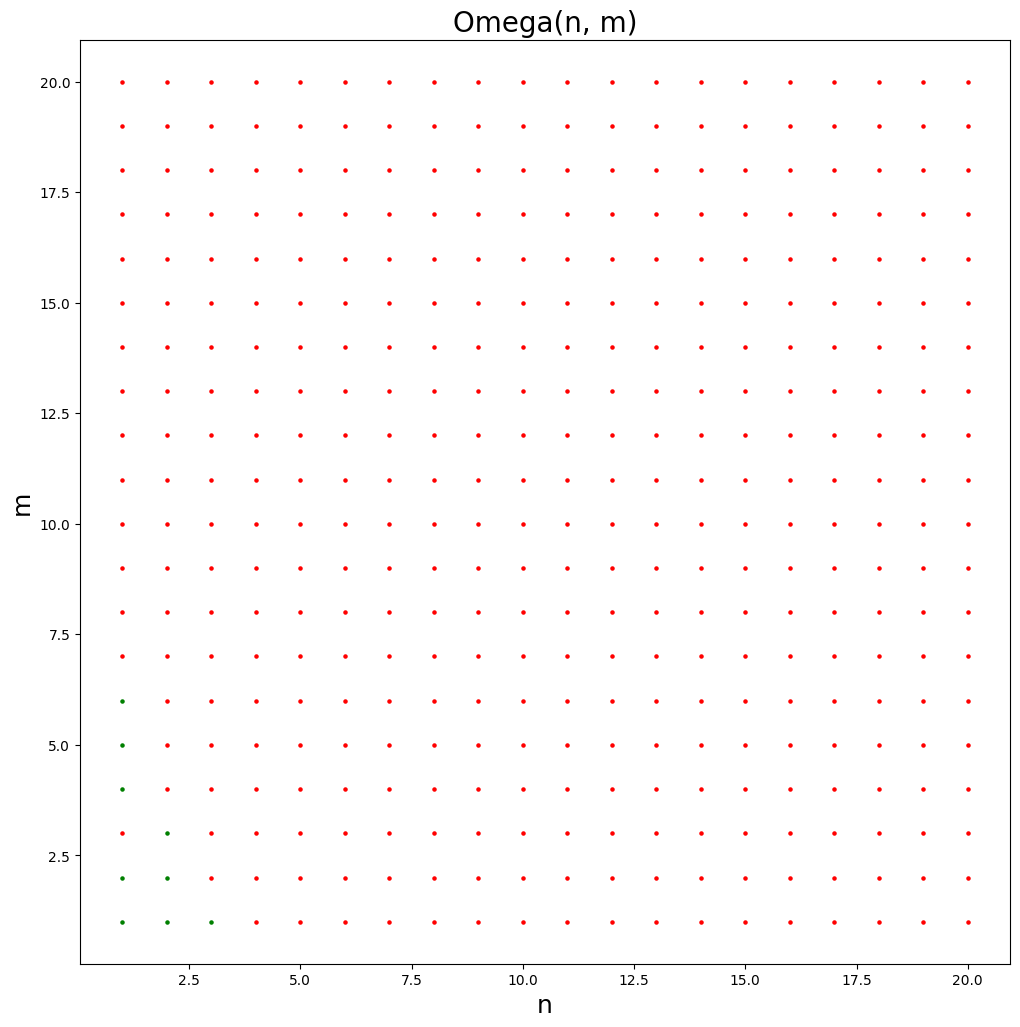

In [41]:
plt.figure(figsize=(12, 12))

green_dots = np.array(green_dots)
red_dots = np.array(red_dots)

plt.scatter(green_dots[:,0], green_dots[:,1], s=5, c='green',)
plt.scatter(red_dots[:,0], red_dots[:,1], s=5, c='red',)

plt.xlabel("n", fontsize=18)
plt.ylabel("m", fontsize=18)
plt.title("Omega(n, m)", fontsize=20)
plt.show()

# Do additional metrics testing

In [9]:
model_name = "v0_lstm_steps_pred_31"

# load the model
with open(f"./fine_models/{model_name}.json", "r") as file:
    loaded_model_json = file.read()

model = tf.keras.models.model_from_json(loaded_model_json)
model.load_weights(f"./fine_models/{model_name}.h5")

In [ ]:
y_train_pred = []
for x_ in x_train:
    y_train_pred.append(model.predict(np.array([x_]), verbose=0)[0])

y_train_pred_nums = encoder.inverse_transform(np.array(y_train_pred))
y_train_nums = encoder.inverse_transform(y_train)

Train accuracy: 0.8353658536585366


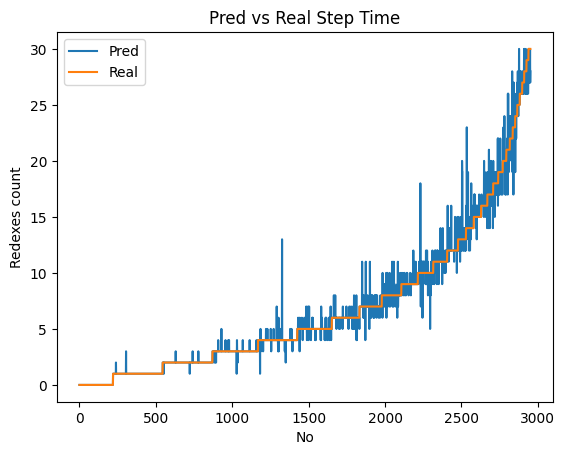

In [12]:
print("Train accuracy:", calculate_accuracy(y_train_nums, y_train_pred_nums))

draw_pred_lines(y_train_pred_nums, y_train_nums)

Test accuracy: 0.2922868741542625


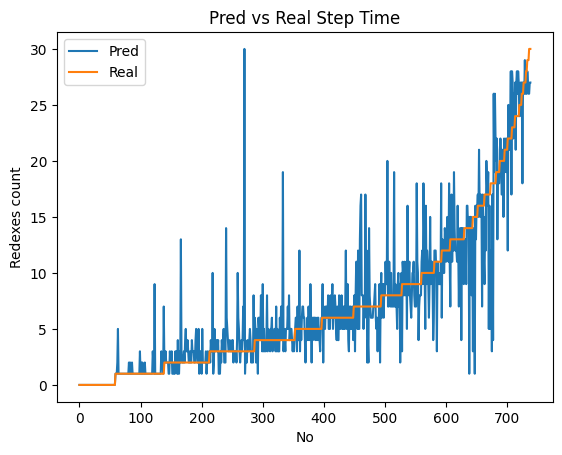

In [13]:
y_test_pred = []
for x_ in tqdm(x_test):
    y_test_pred.append(model.predict(np.array([x_]), verbose=0)[0])

y_test_pred_nums = encoder.inverse_transform(np.array(y_test_pred))
y_test_nums = encoder.inverse_transform(y_test)

print("Test accuracy:", calculate_accuracy(y_test_nums, y_test_pred_nums))

draw_pred_lines(y_test_pred_nums, y_test_nums)

## Mean Squared Error

In [14]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

In [15]:
mse_train = mean_squared_error(y_train_nums, y_train_pred_nums)
print("Train {Mean Squared Error}:", mse_train)

mse_test = mean_squared_error(y_test_nums, y_test_pred_nums)
print("Test {Mean Squared Error}:", mse_test)

Train {Mean Squared Error}: 0.6283875338753387
Test {Mean Squared Error}: 8.878213802435724


## Mean Absolute Error

In [16]:
mae_train = mean_absolute_error(y_train_nums, y_train_pred_nums)
print("Train {Mean Absolute Error}:", mae_train)

mae_test = mean_absolute_error(y_test_nums, y_test_pred_nums)
print("Test {Mean Absolute Error}:", mae_test)

Train {Mean Absolute Error}: 0.2632113821138211
Test {Mean Absolute Error}: 1.665764546684709


## Mean Absolute Percentage Error

In [17]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true_fix = np.array([y_ + 0.0001 for y_ in y_true])
    percentage_errors = np.abs((y_true - y_pred) / y_true_fix) * 100
    mape = np.mean(percentage_errors)
    return mape


mape_train = mean_absolute_percentage_error(y_train_nums, y_train_pred_nums)
print("Train {Mean Absolute Percentage Error}:", mape_train)

mape_test = mean_absolute_percentage_error(y_test_nums, y_test_pred_nums)
print("Test {Mean Absolute Percentage Error}:", mape_test)

Train {Mean Absolute Percentage Error}: 2.746737990498317
Test {Mean Absolute Percentage Error}: 30.01345264583018


## Percentage of Explained Variance (PEV)

In [18]:
# Calculate Variance of the target variable
variance_y_test = np.var(y_test_nums)
variance_y_train = np.var(y_train_nums)

# Calculate Percentage of Explained Variance (PEV)
pev_test = (1 - mse_test / variance_y_test) * 100
pev_train = (1 - mse_train / variance_y_train) * 100

print("Train {Percentage of Explained Variance}:", pev_train)
print("Test {Percentage of Explained Variance}:", pev_test)

Train {Percentage of Explained Variance}: 98.49157030245937
Test {Percentage of Explained Variance}: 79.16511326069839


## Mean Bias Deviation

In [19]:
def mean_bias_deviation(y_true, y_pred):
    y_true_fix = np.array([y_ + 0.0001 for y_ in y_true])
    n = len(y_true)
    mbd = np.sum((y_pred - y_true) / y_true_fix) * 100 / n
    return mbd


mbd_train = mean_bias_deviation(y_train_nums, y_train_pred_nums)
print("Train {Mean Bias Deviation}:", mbd_train)

mdb_test = mean_bias_deviation(y_test_nums, y_test_pred_nums)
print("Test {Mean Bias Deviation}:", mdb_test)

Train {Mean Bias Deviation}: 0.7712875278553489
Test {Mean Bias Deviation}: 12.360834287032976


## Coefficient of Correlation (Pearson's r)

In [20]:
coc_test = np.corrcoef(y_test_pred_nums, y_test_nums)[0, 1]
coc_train = np.corrcoef(y_train_pred_nums, y_train_nums)[0, 1]

print("Train {Mean Bias Deviation}:", coc_train)
print("Test {Mean Bias Deviation}:", coc_test)

Train {Mean Bias Deviation}: 0.9926247771131942
Test {Mean Bias Deviation}: 0.8992879019701872


In [21]:
y_test_nums

array([ 2,  9,  4, 18,  5,  5,  7,  7, 30,  5,  8, 23, 21,  1,  1, 27,  1,
        3,  2, 11,  7,  8,  5,  6,  4,  2,  4,  0,  3,  8,  0,  2,  0,  7,
        0,  6,  7,  3, 13,  5,  0,  4,  1,  0,  7, 11, 13,  1,  8,  8,  4,
        5,  2,  3,  9, 23,  4,  9, 16,  1,  6,  3,  4,  2,  8,  5,  2,  4,
        3,  3,  0,  5, 11,  9, 10, 17,  8,  5, 10, 22,  0, 16,  1, 11,  3,
        3,  1, 23,  2,  4, 24,  7,  6, 17,  3,  4,  2, 13,  0,  5, 20,  1,
       10,  1,  0,  3,  7, 10, 13,  2,  8,  2, 14,  7,  8,  3,  3,  2,  3,
       25,  7,  1, 16,  2,  6, 18,  0,  4,  5,  6,  3,  2, 13,  9,  7,  1,
        0, 11,  6,  3, 13, 12,  5,  6,  0,  3,  7,  4,  1,  5,  6,  0,  3,
        7,  2,  8,  9,  4,  2, 17,  3,  4,  2,  3,  3, 16, 13, 22,  5,  3,
        5,  2,  4,  2,  2,  8,  6,  3, 13,  5,  2,  2,  6,  0, 20,  7,  4,
       21,  9,  1,  3,  9,  6,  4, 19,  4,  4,  1,  5,  9, 14,  1,  8, 14,
        1,  3,  9,  8,  1,  3, 21,  0, 10,  2,  5, 10,  5,  5,  8, 12, 10,
        6, 15,  5,  0,  1